# Autoencoders

## Tasks

### Task 1

Train an autoencoder on the `MNIST` dataset, try to make it with an embedding size no larger than 128.   
Generate embeddings for a thousand objects from the training sample.  
Train a `Random Forest` on these embeddings.  
**Achieve an Accuracy greater than 90%.**

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torchvision.transforms as T
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math
from typing import List

In [2]:
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    for x, _ in tqdm(data_loader, desc='train'):
        x = x.to(device)

        optimizer.zero_grad()

        outputs: torch.Tensor = model(x)
        loss = loss_fn(outputs, x)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)

    return train_loss

@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device):
    model.eval()
    total_loss = 0
    for x, y in tqdm(data_loader, desc='evaluate'):
        x = x.to(device)
        outputs = model(x)
        _, y_predicted = torch.max(outputs.data, 1)
       
        loss = loss_fn(outputs, x)
        
        total_loss += loss.item()
    total_loss /= len(data_loader)
    return total_loss

def plot_stats(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float], title: str):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss For {title}')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(train_accuracies, label='Train Accuracy' )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Validation Accuracy For {title}')
    plt.grid()
    plt.show()


@torch.inference_mode()
def visualize(model, xs, device):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()

def train_cycle(model, num_epochs, train_loader, val_loader, optimizer, title, loss_fn, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        clear_output()
        visualize(model, next(iter(valid_loader))[0], device)

        plot_stats(train_losses, val_losses, train_accuracies, val_accuracies, title)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [5]:
class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
#print(torch.cuda.get_device_name())

loss_fn = nn.MSELoss()

cuda:0


In [7]:
de_model = DenoisingAutoEncoder(in_channels=1, num_blocks=5).to(device)

optimizer = Adam(de_model.parameters(), lr=1e-3)

In [8]:
x = train_dataset[0][0]

In [9]:
x.unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [10]:
de_model.encode(x.unsqueeze(0).to(device)).shape

torch.Size([1, 128])

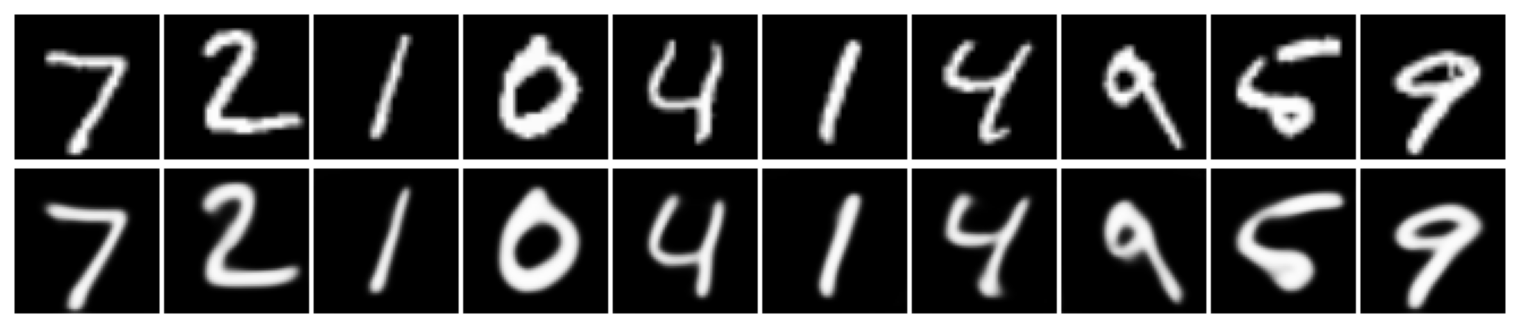

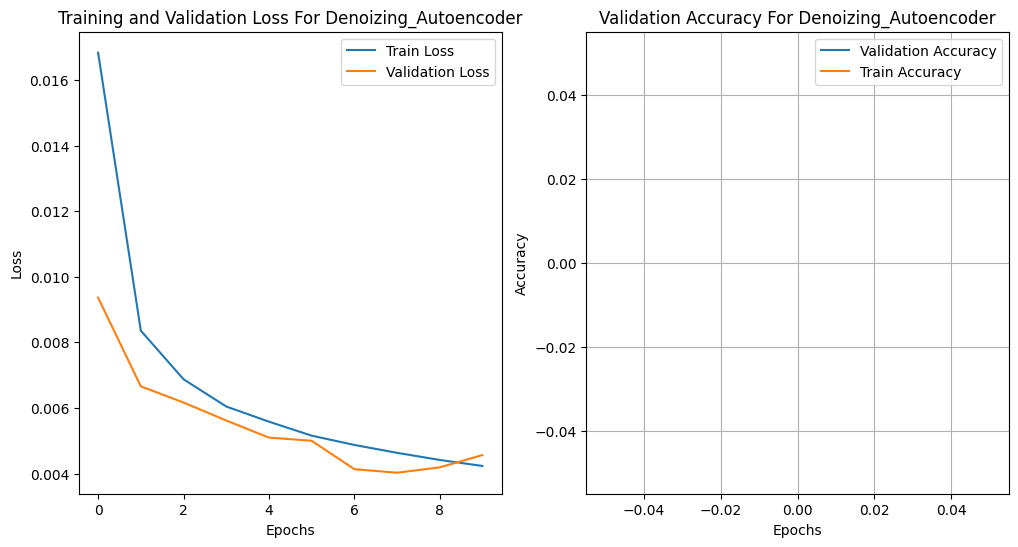

Epoch 10/10, Train Loss: 0.0042, Val Loss: 0.0046


In [11]:
train_cycle(de_model, 10, train_loader, valid_loader, optimizer, 'Denoizing_Autoencoder', loss_fn, device)

In [12]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None):
    model.eval()
    
    total = 0
    
    latent = []
    labels = []
    
    for x, y in loader:
        z = model.encode(x.to(device)).cpu()
        
        latent.append(z)
        labels.append(y)
        
        total += y.shape[0]
        
        if count is not None and total >= count:
            break
            
    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()
    
    return latent, labels

In [13]:
training_data = get_latent_labels(de_model, train_loader, count=1000)

In [14]:
training_data[0].shape

(1000, 128)

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
classifier = RandomForestClassifier(random_state=0)

In [17]:
classifier.fit(training_data[0], training_data[1])

RandomForestClassifier(random_state=0)

In [18]:
validation_data = get_latent_labels(de_model, valid_loader, count=10000)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
validation_predictions = classifier.predict(validation_data[0])

In [20]:
(validation_predictions == validation_data[1]).mean()

0.9348

In [21]:
def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    # Convert numpy arrays to pytorch tensors if needed
    if isinstance(x_train, np.ndarray):
        x_train = torch.from_numpy(x_train).to(torch.float16)
    else:
        x_train = x_train.to(torch.float16)
        
    if isinstance(x_valid, np.ndarray):
        x_valid = torch.from_numpy(x_valid).to(torch.float16)
    else:
        x_valid = x_valid.to(torch.float16)
        
    if isinstance(y_train, np.ndarray):
        y_train = torch.from_numpy(y_train).to(torch.int8)
    else:
        y_train = y_train.to(torch.int8)
        
    if isinstance(y_valid, np.ndarray):
        y_valid = torch.from_numpy(y_valid).to(torch.int8)
    else:
        y_valid = y_valid.to(torch.int8)

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

In [22]:
save_embeddings(training_data[0], training_data[1], validation_data[0], validation_data[1])